# 1. Data Preprocessing

## Getting the dataset from Kaggle
1. Get a new API token (kaggle.json).
2. Save to specified directory.
3. Run the following kaggle command to download the dataset.

In [1]:
!kaggle datasets download -d gpiosenka/100-bird-species --force


  0%|          | 0.00/1.96G [00:00<?, ?B/s]
  0%|          | 1.00M/1.96G [00:00<20:00, 1.75MB/s]
  0%|          | 3.00M/1.96G [00:00<06:53, 5.07MB/s]
  0%|          | 7.00M/1.96G [00:00<02:55, 12.0MB/s]
  0%|          | 9.00M/1.96G [00:00<02:39, 13.1MB/s]
  1%|          | 12.0M/1.96G [00:01<02:02, 17.0MB/s]
  1%|          | 15.0M/1.96G [00:01<01:52, 18.4MB/s]
  1%|          | 18.0M/1.96G [00:01<01:42, 20.3MB/s]
  1%|1         | 21.0M/1.96G [00:01<01:44, 19.9MB/s]
  1%|1         | 24.0M/1.96G [00:01<01:35, 21.7MB/s]
  1%|1         | 27.0M/1.96G [00:01<01:36, 21.5MB/s]
  1%|1         | 30.0M/1.96G [00:02<02:10, 15.8MB/s]
  2%|1         | 34.0M/1.96G [00:02<01:54, 18.1MB/s]
  2%|1         | 37.0M/1.96G [00:02<01:41, 20.3MB/s]
  2%|2         | 41.0M/1.96G [00:02<01:39, 20.6MB/s]
  2%|2         | 44.0M/1.96G [00:02<01:50, 18.5MB/s]
  2%|2         | 49.0M/1.96G [00:03<01:53, 18.0MB/s]
  3%|2         | 51.0M/1.96G [00:03<02:07, 16.1MB/s]
  3%|2         | 56.0M/1.96G [00:03<01:33, 21.8MB/s]
 

## Unzip and extract the images

In [2]:
zipPath = '100-bird-species.zip'
dirPath = zipPath[:zipPath.find('.')]

In [22]:
from zipfile import ZipFile
with ZipFile(zipPath) as f:
    f.extractall(dirPath)

## Preliminary exploration of the data
According to the description on the kaggle page for the dataset, the dataset is gathered by searching for images of each bird species and then combed through to remove duplicates.

Further, it is curated manually into the train, test, and valid sets, which the author claims to give the highest accuracy. However, in order to ensure a model is empirical and gives high accuracy on new arbitrary images, it is decided that the following explorations should occur as a preliminary step.

1. Combine the 3 sets of data as one dataset.
2. Shuffle the dataset.
3. Resplit the dataset into 3 sets.

In [23]:
import os
import pandas as pd

catalogPath = os.path.join(dirPath, 'birds.csv')

df = pd.read_csv(catalogPath)
df.columns

Index(['class id', 'filepaths', 'labels', 'data set', 'scientific name'], dtype='object')

In [24]:
summary = df.groupby('scientific name')['filepaths'].count()
df_agg = summary.agg(['min', 'max', 'mean'])
countMin = df_agg['min'].astype('uint8')
df_agg

min     140.000000
max     364.000000
mean    172.193487
Name: filepaths, dtype: float64

TODO: plot barchart for each species no. of images

In [25]:
df['filepaths'].count()

89885

As evidenced above, there is a problem of an imbalanced dataset, where each of the 525 classes does not the same number of samples. This is problematic because it can cause a bias in a classifier trained from the dataset.

For example, for a binary classifier, we can get a baseline accuracy of 50% just by always returning the same label on a balanced dataset. And for a multiclass classifier, we would expect an accuracy of $\frac{100\%}{525}=0.19\%$ from a balanced dataset but due to the inbalanced dataset, we can observe anywhere in the range of $(\frac{140}{89885},\frac{384}{89885})=(0.16\%,0.43\%)$ on a baseline classifier that always return the same label depending only one which label we choose to return.

To prevent this problem, we will use the technique of undersampling, where only the minimum number of 140 images will be randomly selected from each class and split into a ratio 5:1:1 for the balanced train, test, validation sets that will be performed once and kept as a static dataset to ensure fairness across the experiments.

The ratio of 5:1:1 also roughly approximates to a $70\%,15\%,15\%$ split which is a quite a common splitting ratio.

Originally, there's a total of 89885 images, by reducing each class to 140 images, we have a resulting dataset consisting of $140\times525=73500$ images, which is a $18\%$ reduction in the number of images, is still a massive dataset that is balanced and can improve the performance of the model to be trained.

In [26]:
classes = df['labels'].unique()
n_classes = len(classes)
n_classes

525

The random seed for the random library is set as a set number of samples will be taken from the dataset and to ensure consistency between runs.

In [27]:
import random
seed = 42
random.seed(seed)

As discussed previously, it was decided early to use the 5:1:1 or 70%, 15%, 15% for the 140 images per class, but rounding to whole numbers, this resulted in a split of 98, 21, 21. To even up the the subsets, it was further decided to split the images into subsets of 100, 20, 20 for the training, test and validation subsets respectively.

In [28]:
#ratio_train = 0.7
#ratio_test = 0.15

#n_train = int(ratio_train * countMin)
#n_test = int(ratio_test * countMin)
pathsSub = ['train', 'test', 'valid']
n_subsets = [100, 20, 20]

for i in range(len(n_subsets)):
    print('{} samples: {} per class, {} total files'.format(
        pathsSub[i], n_subsets[i],  n_subsets[i] * n_classes))

train samples: 100 per class, 52500 total files
test samples: 20 per class, 10500 total files
valid samples: 20 per class, 10500 total files


In [29]:
import shutil
import pathlib

pathOld = pathlib.Path(dirPath)
pathNew = pathlib.Path('data')
pathsSub = ['train', 'test', 'valid']

The following cell is necessary as there are some irregularities in the dataset. For example, for the species 'PARAKETT AUKLET', the sub folder within the training dataset has an extra space ('PARAKETT  AUKLET') while the validation dataset has no extra space, resulting in error being thrown during later processing.

In [30]:
for pathSub in pathsSub:
    pathsSpecies= os.listdir(pathOld / pathSub)
    for pathSpecies in pathsSpecies:
        pathSpeciesNew = ' '.join(pathSpecies.split())
        os.rename(pathOld / pathSub/ pathSpecies, 
                  pathOld/ pathSub/ pathSpeciesNew)

In [31]:
pathsSpecies = os.listdir(pathOld / pathsSub[0])

In [32]:
if os.path.isdir(pathNew):
    shutil.rmtree(pathNew)
        
os.mkdir(pathNew)
for pathSub in pathsSub:
    os.mkdir(pathNew / pathSub)
    for pathSpecies in pathsSpecies:
        pathSpecies = '_'.join(pathSpecies.lower().split())
        os.mkdir(pathNew / pathSub / pathSpecies)

In [33]:
for pathSpecies in pathsSpecies:
    pathsFile = []
    # get all files for a given species
    for pathSub in pathsSub:
        pathsCurr = os.listdir(pathOld / pathSub / pathSpecies)
        for pathFile in pathsCurr:
            pathsFile.append(pathOld / pathSub / pathSpecies / pathFile)
    pathsFile = random.sample(pathsFile, countMin)
    
    limit = 0
    j = 0
    for i in range(len(pathsSub)):
        limit += n_subsets[i]
        k = 1
        while j < limit:
            pathSrc = pathsFile[j]
            species = '_'.join(pathSpecies.lower().split())
            filename = '{}.{}.jpg'.format(species, k)
            pathDst = pathNew / pathsSub[i] / species / filename
            shutil.copyfile(src=pathSrc, dst=pathDst)
            j += 1            
            k += 1

In [34]:
shutil.rmtree(pathOld)
os.remove(zipPath)

# 2. Experiments

## Experiment Preparations

The following cell contains configuration that is necessary for the functions defined later and used within the experiments.

In [1]:
img_size = (224, 224)
n_batch = 64
n_epochs=1000
p_root = 'data'
p_train = 'train'
p_test = 'test'
p_valid = 'valid'
p_imgs = 'img'
p_models = 'models'
p_logs = 'logs'
p_histories = 'history'
random_seed = 42
e_plot = '.png'
e_model = '.keras'
factor_lr = 0.25
min_lr = 0.0001
patience_earlyStopping = 20
patience_reduceLR = 2
rand_rotation = 0.1
rand_zoom = 0.2
rate_dropout = 0.5
flag_early_stopping = True
create_new = True
images_per_row = 16
image_margin = 5
top_k = 5
visualize_species = 14
visualize_sample = 4
s_activation = 'activation_layer'
s_max = 'max_layer'

p_experiment_exp_1 = '01_basic'
p_experiment_exp_2 = '02_rescaling'
p_experiment_exp_3 = '03_added_width'
p_experiment_exp_4 = '04_added_depth'
p_experiment_exp_5 = '05_fc_dense'
p_experiment_exp_6 = '06_dropout'
p_experiment_exp_7 = '07_residual'
p_experiment_exp_8 = '08_residual_max'
p_experiment_exp_9 = '09_residual_depth'
p_experiment_exp_10 = '10_augmented'

All the libraries that are/ may be used. This is put into one place to facilitate reuse, since some of the model training cells takes a long time to run and the notebook itself is never meant to be ran in one go.

In [2]:
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import random
import seaborn as sns
import shutil
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

In [3]:
tf.random.set_seed(random_seed)

input_size = img_size + (3,)

INDEX_TRAIN = 0
INDEX_VALID = 1
INDEX_TEST = 2

In [4]:
def create_paths():
    paths = {
        'root': pathlib.Path(p_root),
        'models': pathlib.Path(p_models),
        'logs': pathlib.Path(p_logs),
        'img': pathlib.Path(p_imgs),
        'histories': pathlib.Path(p_histories)
    }
    
    if not os.path.exists(paths['models']):
        os.mkdir(paths['models'])
    if not os.path.exists(paths['logs']):
        os.mkdir(paths['logs'])
    if not os.path.exists(paths['img']):
        os.mkdir(paths['img'])
    if not os.path.exists(paths['histories']):
        os.mkdir(paths['histories'])
    
    paths['train'] = paths['root'] / p_train
    paths['valid'] = paths['root'] / p_valid
    paths['test'] = paths['root'] / p_test
    
    return paths

In [5]:
def create_dir(path):
    if create_new:
        if os.path.isdir(path):
            shutil.rmtree(path)
        os.makedirs(path)
    else:
        if not os.path.isdir(path):
            os.makedirs(path)

def update_paths(experiment, paths):
    paths = paths.copy()
    paths['experiment'] = pathlib.Path(p_models) / experiment
    paths['model'] = paths['experiment'] / (experiment + e_model)
    paths['log'] = paths['logs'] / experiment
    paths['plot'] = paths['img'] / experiment
    paths['history'] = paths['histories'] / experiment
    paths['plot_model'] = paths['plot'] / (experiment + \
        '_model' + e_plot)
    paths['plot_evaluation'] = paths['plot'] / (experiment + \
        '_evaluation' + e_plot)    
    paths['cf'] = paths['plot'] / (experiment + \
        '_confusion_matrix' + e_plot)
    paths['history_file'] = paths['history'] / (experiment + \
        '.json')    
    
    create_dir(paths['experiment'])
    create_dir(paths['log'])
    create_dir(paths['plot'])
    create_dir(paths['history'])
    
    return paths

In [6]:
def get_datasets(paths):
    dsTrain = image_dataset_from_directory(
        paths['train'],
        image_size=img_size,
        seed=random_seed,
        batch_size=n_batch)
    dsValid = image_dataset_from_directory(
        paths['valid'],
        image_size=img_size,
        seed=random_seed,
        batch_size=n_batch)
    dsTest = image_dataset_from_directory(
        paths['test'],
        image_size=img_size,
        seed=random_seed,
        batch_size=n_batch,
        shuffle=False)
    return dsTrain, dsValid, dsTest

In [7]:
def create_callbacks(paths):
    callbacks = []
    cb_modelCheckpoint = keras.callbacks.ModelCheckpoint(
        filepath=paths['model'],
        save_best_only=True,
        monitor='val_loss',
        verbose=True
    )
    callbacks.append(cb_modelCheckpoint)

    cb_tensorboard = keras.callbacks.TensorBoard(
        log_dir=paths['log']
    )
    callbacks.append(cb_tensorboard)
    
    cb_reduceLR = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=factor_lr,
        min_lr=min_lr,
        patience=patience_reduceLR,
        verbose=True
    )
    callbacks.append(cb_reduceLR)
    
    if  flag_early_stopping:
        cb_earlyStopping = keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=patience_earlyStopping,
            verbose=True
        )
        callbacks.append(cb_earlyStopping)

    return callbacks

In [8]:
def plot_accuracy_loss(history, paths):
    plt.figure(figsize=(18, 6))
    plt.subplot(131)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = [i + 1 for i in range(len(acc))]
    plt.plot(epochs, acc, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(132)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
    plt.title('Loss')
    plt.legend()    
    
    plt.subplot(133)
    loss = history.history['sparse_top_k_categorical_accuracy']
    val_loss = history.history['val_sparse_top_k_categorical_accuracy']
    plt.plot(epochs, loss, 'bo', label='Training Top-{} Accuracy'.format(top_k))
    plt.plot(epochs, val_loss, 'b-', label='Validation Top-{} Accuracy'.format(top_k))
    plt.title('Top-{} Accuracy'.format(top_k))
    plt.legend()
    plt.savefig(paths['plot_evaluation'])

In [9]:
def save_history(history, paths):
    df_history = pd.DataFrame(history.history)
    df_history.to_csv(paths['history_file'], index=False)

In [10]:
def run_experiment(create_model, paths):
    model = create_model()
    print(model.summary())
    keras.utils.plot_model(model, 
                           show_shapes=True,
                           to_file=paths['plot_model'])    
    
    callbacks = create_callbacks(paths)    
    
    model.compile(optimizer='rmsprop',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy', tf.metrics.SparseTopKCategoricalAccuracy(k=top_k)])
    
    history = model.fit(datasets[INDEX_TRAIN], 
                    epochs=n_epochs,
                    validation_data=datasets[INDEX_VALID],
                    callbacks=callbacks)
    plot_accuracy_loss(history, paths)
    model = keras.models.load_model(paths['model'])
    save_history(history, paths)
    
    result = model.evaluate(datasets[INDEX_TEST])    
    result = {
        'loss': result[0],
        'accuracy': result[1],
        'sparse_top_k_categorical_accuracy': result[2]
    }
        
    return result

In [11]:
def create_augmentation_layer():
    augmentation_layer = keras.Sequential([
        layers.RandomFlip('horizontal',
        seed=random_seed),
        layers.RandomRotation(rand_rotation,
        seed=random_seed),
        layers.RandomZoom(rand_zoom,
        seed=random_seed)
    ])
    return augmentation_layer    

In [12]:
def add_residual_block(x, filters, n_layers,
                          pooling=True):
    residual = x
    
    for i in range(n_layers):
        x = layers.Conv2D(filters=filters, kernel_size=3,
                          activation='relu',
                          padding='same')(x)
    if pooling:
        x = layers.MaxPooling2D(pool_size=2)(x)
        residual = layers.Conv2D(filters=filters, kernel_size=1, 
                                 strides=2)(residual)
    elif filters != residual.shape[-1]:
        residual = layers.Conv2D(filters=filters, kernel_size=1)\
            (residual)
    x = layers.add([x, residual])
    return x            

In [13]:
paths = create_paths()
datasets = get_datasets(paths)
n_classes  = len(datasets[INDEX_TRAIN].class_names)
y_true = np.concatenate([y for x, y in datasets[INDEX_TEST]])

Found 52500 files belonging to 525 classes.
Found 10500 files belonging to 525 classes.
Found 10500 files belonging to 525 classes.


In [14]:
def plot_confusion_matrix(y_true, y_pred,
                          classes=None, figsize=(25, 25),
                          text_size=8, norm=False, savefig=True,
                          path='confusion_matrix.png'):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
    n_classes = cm.shape[0]
    
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
    
    ax.set(title='Confusion Matrix',
           xlabel='Predicted label',
           ylabel='True label',
           xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=labels,
           yticklabels=labels)
    
    ax.xaxis.set_label_position('bottom')
    ax.xaxis.tick_bottom()
    
    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)
    
    threshold = (cm.max() + cm.min()) / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f'{cm[i, j]} ({cm_norm[i,j]*100:1f%}',
                     color='white' if cm[i, j] > threshold else 'black', 
                     size=text_size)
        else:
            plt.text(j, i, f'{cm[i,j]}',
                     horizontalalignment='center',
                     color='white' if cm[i, j] > threshold else 'black',
                     size=text_size)
    
    if savefig:
        fig.savefig(path)
    plt.close()

In [15]:
def evaluate_cf(experiment, paths):    
    global create_new
    create_new = False
    paths_tmp = update_paths(experiment, paths)    
    model = keras.models.load_model(paths_tmp['model'])
    
    result = model.predict(datasets[INDEX_TEST])
    y_pred = [np.argmax(x) for x in result]
    plot_confusion_matrix(y_true, y_pred, datasets[2].class_names,
                          figsize=(100, 100), text_size=8, savefig=True, 
                          path=paths_tmp['cf'])
    create_new = True

In [16]:
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img)
    img = tf.image.resize(img, size=img_size)
    return img

In [17]:
def getTestImage(paths, species=None, sample=None):    
    classes = os.listdir(paths['test'])
    if species is None:
        species = random.randrange(len(classes))
    samples = os.listdir(paths['test'] / classes[species])
    if sample is None:
        sample = random.randrange(len(samples))
    path  = str(paths['test']/classes[species]/samples[sample])
    img = load_image(path)
    return img, species

In [18]:
def evaluate_random(experiment, paths):
    global create_new
    create_new = False
    paths_tmp = update_paths(experiment, paths)    
    model = keras.models.load_model(paths_tmp['model'])
   
    classes = os.listdir(paths['test'])
    x, y_true = getTestImage(paths)
    y_pred = np.argmax(model.predict( tf.expand_dims(x, axis=0)))
    
    print('{}, {}'.format(y_pred, y_true))
    
    sOut = f'Prediction: {classes[y_pred]}'
    cOut = 'blue'
    if y_pred != y_true:
        cOut = 'red'
        sOut += f' (Correct: {classes[y_true]})'
    
    img = x / 255.
    fig, ax = plt.subplots(1, 1)
    ax.imshow(img)
    ax.set_title(sOut, color=cOut) 
    create_new = True

In [19]:
def visualizeActivations(experiment):
    global create_new
    create_new = False
    paths_tmp = update_paths(experiment, paths)    
    model = keras.models.load_model(paths_tmp['model'])
    
    x, _ = getTestImage(paths, visualize_species, visualize_sample)
    #plt.imshow(x / 255.)
    
    layerOutputs = []
    layerNames = []
    for layer in model.layers:
        if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
            layerOutputs.append(layer.output)
            layerNames.append(layer.name)
    activationModel = keras.Model(inputs=model.input, outputs=layerOutputs)
    
    activations = activationModel.predict(tf.expand_dims(x, axis=0))
    
    i = 1
    for layer, activation in zip(layerNames, activations):
        n_features = activation.shape[-1]
        size = activation.shape[1]
        n_rows = n_features // images_per_row
        display_grid = np.zeros(((size+1) * n_rows - 1,
                                 images_per_row * (size+1)-1))
        
        for row in range(n_rows):
            for col in range(images_per_row):
                channel_index = row * images_per_row + col
                channel_image = activation[0, :, :, channel_index].copy()
                if channel_image.sum() != 0:
                    channel_image -= channel_image.mean()
                    channel_image /= channel_image.std()
                    channel_image *= 64
                    channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[
                    row * (size + 1): (row + 1) * size + row,
                    col * (size + 1): (col + 1) * size + col] = channel_image
        scale = 1. / size        
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer)
        plt.grid(False)
        plt.axis('off')
        plt.imshow(display_grid, aspect='auto', cmap='viridis')        
        plt.savefig(paths_tmp['plot'] / ('{}_{}_{}{}'.format(
            s_activation, i, layer, e_plot)))
        plt.close()
        i += 1
    create_new = True

In [20]:
def compute_loss(image, filterIndex, featureExtractor):
    activation = featureExtractor(image)
    filterActivation = activation[:, 2:-2, 2:-2, filterIndex]
    return tf.reduce_mean(filterActivation)

@tf.function
def gradient_ascent_step(image, filterIndex, learningRate, featureExtractor):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filterIndex, featureExtractor)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learningRate * grads
    return image

def generate_filter_pattern(filterIndex, featureExtractor):
    iterations = 30
    learningRate = 10.
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,
        shape=(1, img_size[0], img_size[1], 3))
    for i in range(iterations):
        image = gradient_ascent_step(image, filterIndex, learningRate, featureExtractor)
    return image[0].numpy()

def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype('uint8')
    image = image[25:-25, 25:-25, :]
    return image

In [21]:
def visualizeMaxActivations(experiment):    
    global create_new
    create_new = False
    paths_tmp = update_paths(experiment, paths)    
    model = keras.models.load_model(paths_tmp['model'])
    
    layerNames = []
    for layer in model.layers:
        if isinstance(layer, (layers.Conv2D, layers.SeparableConv2D)):
            layerNames.append(layer.name)
            
    k = 1
    for layerName in layerNames:
        layer = model.get_layer(name=layerName)
        featureExtractor = keras.Model(inputs=model.input, outputs=layer.output)
        
        allImages = []
        nFilters = layer.output_shape[-1]
        for filterIndex in range(nFilters):
            image = deprocess_image(generate_filter_pattern(filterIndex, featureExtractor))
            allImages.append(image)
        
        n_rows = nFilters // images_per_row    
        cropped_width = img_size[1] - 25 * 2
        cropped_height = img_size[0] - 25 * 2
        width = images_per_row * cropped_width + (images_per_row-1) * image_margin
        height = n_rows * cropped_height + (n_rows-1) * image_margin
        stitched_filters = np.zeros((height, width, 3))
        
        for i in range(n_rows):
            for j in range(images_per_row):
                image = allImages[i*images_per_row+j]
                row_start = (cropped_height + image_margin)*i
                row_end = (cropped_height + image_margin)*i + cropped_height
                column_start = (cropped_width + image_margin) * j
                column_end = (cropped_width + image_margin) * j + cropped_width
                
                stitched_filters[row_start:row_end,
                                 column_start:column_end, :] = image
        
        
        scale = 1. / cropped_width       
        plt.figure(figsize=(scale * stitched_filters.shape[1],
                            scale * stitched_filters.shape[0]))
        plt.title(layerName)
        plt.grid(False)
        plt.axis('off')
        plt.imshow(stitched_filters.astype('uint8'), aspect='auto')         
        plt.savefig(paths_tmp['plot'] / ('{}_{}_{}{}'.format(
            s_max, k, layerName, e_plot)))   
        plt.close()
        k += 1

    create_new = True

In [22]:
# l7.15 creating a Functional model that includes a subclassed model
class Classifier(keras.Model):
    def __init__(self, num_classes=2):
        super().__init__()
        if num_classes == 2:
            num_units = 1
            activation = 'sigmoid'
        else:
            num_units = num_classes
            activation = 'softmax'
        self.dense = layers.Dense(num_units, activation=activation)
        
    def call(self, inputs):
        return self.dense(inputs)
    
inputs = keras.Input(shape=(3,))
features = layers.Dense(64, activation='relu')(inputs)
outputs = Classifier(num_classes=10)(features)
model = keras.Model(inputs=inputs, outputs=outputs)

## Prototyping stage

### Experiment 1: Basic model (Baseline)

In [41]:
def create_model_exp_1():
    inputs = keras.Input(shape=input_size)
    x = layers.Conv2D(filters=32, kernel_size=3, 
                      activation='relu', 
                      padding='same')(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, 
                      activation='relu', 
                      padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, 
                      activation='relu', 
                      padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, 
                      activation='relu', 
                      padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, 
                      activation='relu', 
                      padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
                  
    return model

In [42]:
paths_exp_1 = update_paths(p_experiment_exp_1, paths)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 56, 56, 128)       7385

{'loss': 2.6905910968780518,
 'accuracy': 0.54666668176651,
 'sparse_top_k_categorical_accuracy': 0.7511428594589233}

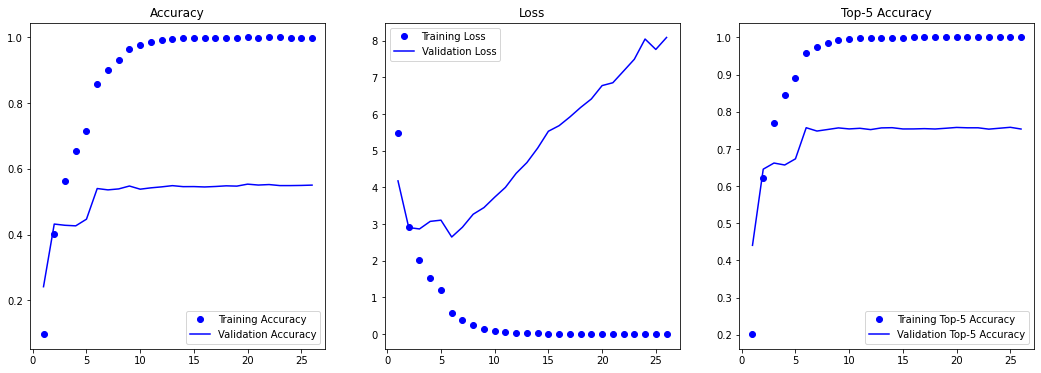

In [43]:
run_experiment(create_model_exp_1, paths_exp_1)

In [43]:
visualizeActivations(p_experiment_exp_1)

1/1 [==============================] - 0s 68ms/step


In [44]:
visualizeMaxActivations(p_experiment_exp_1)

In [45]:
evaluate_cf(p_experiment_exp_1, paths)

165/165 [==============================] - 5s 28ms/step


335, 1
1/1 [==============================] - 0s 73ms/step
335, 335


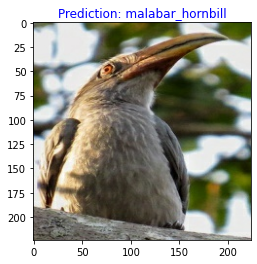

In [38]:
evaluate_random(p_experiment_exp_1, paths)

445, 12
1/1 [==============================] - 0s 65ms/step
152, 445


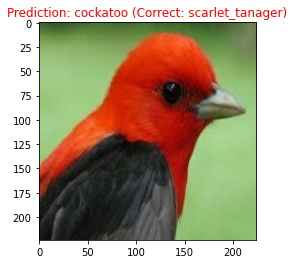

In [41]:
evaluate_random(p_experiment_exp_1, paths)

Compared to the previous analysis where a dummy classifier that always returns the same label for any input and having an accuracy of $0.19\%$, this baseline classifier provides an accuracy of $37.15\%$, which although is not state of the art is way better than the previous estimate.

In future experiments, it will be explored if adding capacity to the model can help improve performance of the model.

### Experiment 2. Adding rescaling

In [23]:
def create_model_exp_2():
    inputs = keras.Input(shape=input_size)
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(filters=32, kernel_size=3, 
                      activation='relu', 
                      padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, 
                      activation='relu', 
                      padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, 
                      activation='relu', 
                      padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, 
                      activation='relu', 
                      padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, 
                      activation='relu', 
                      padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
                  
    return model

In [24]:
paths_exp_2 = update_paths(p_experiment_exp_2, paths)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                       

{'loss': 2.3756439685821533,
 'accuracy': 0.5146666765213013,
 'sparse_top_k_categorical_accuracy': 0.7351428866386414}

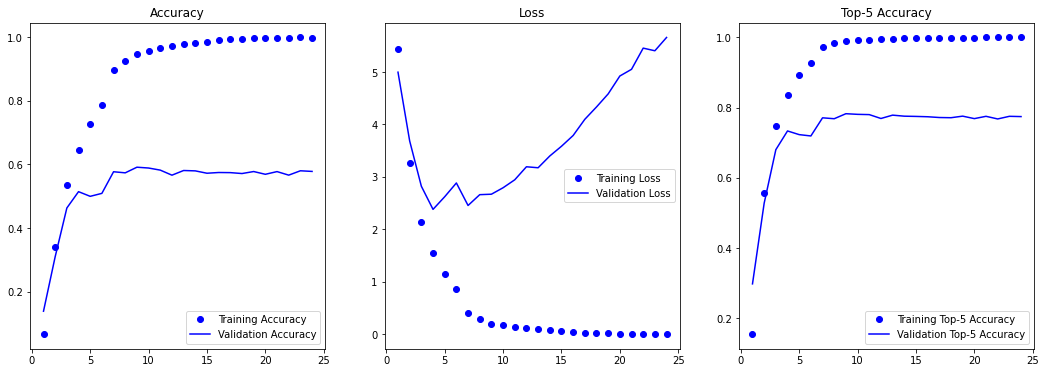

In [25]:
run_experiment(create_model_exp_2, paths_exp_2)

In [35]:
visualizeActivations(p_experiment_exp_2)

14, 4
1/1 [==============================] - 0s 74ms/step


In [36]:
visualizeMaxActivations(p_experiment_exp_2)

In [37]:
evaluate_cf(p_experiment_exp_2, paths)

165/165 [==============================] - 5s 27ms/step


147, 4
1/1 [==============================] - 0s 68ms/step
147, 147


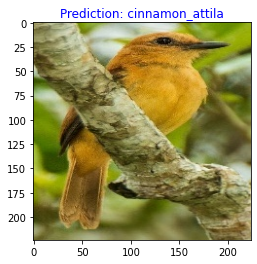

In [45]:
evaluate_random(p_experiment_exp_2, paths)

88, 1
1/1 [==============================] - 0s 67ms/step
87, 88


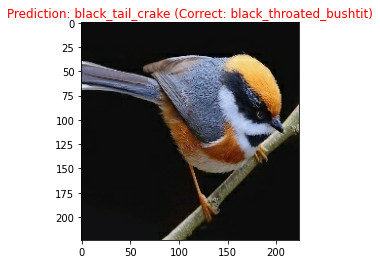

In [52]:
evaluate_random(p_experiment_exp_2, paths)

### Experiment 3. Adding more capacity (width)

In [59]:
def create_model_exp_3():
    inputs = keras.Input(shape=input_size)
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(filters=64, kernel_size=3, 
                      activation='relu', 
                      padding='same')(x)    
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, 
                      activation='relu', 
                      padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, 
                      activation='relu', 
                      padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=512, kernel_size=3, 
                      activation='relu', 
                      padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=512, kernel_size=3, 
                      activation='relu', 
                      padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
                  
    return model

In [60]:
paths_exp_3 = update_paths(p_experiment_exp_3, paths)

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                     

{'loss': 2.278571367263794,
 'accuracy': 0.541523814201355,
 'sparse_top_k_categorical_accuracy': 0.7547619342803955}

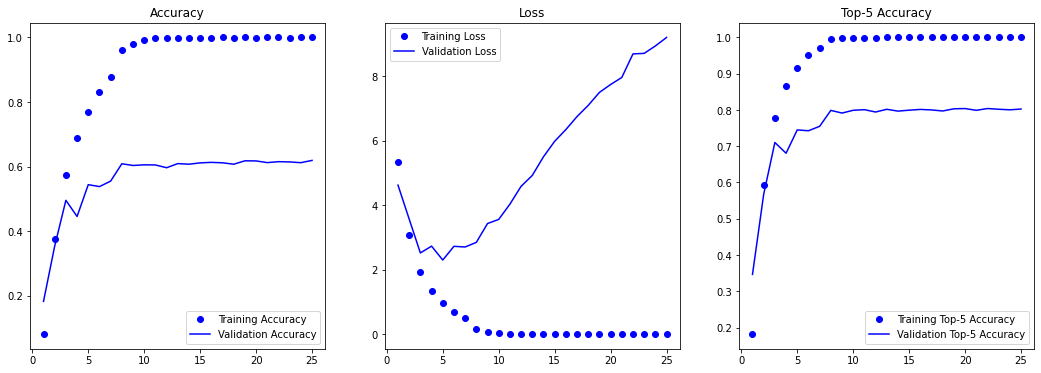

In [61]:
run_experiment(create_model_exp_3, paths_exp_3)

In [83]:
visualizeActivations(p_experiment_exp_3)

1/1 [==============================] - 1s 505ms/step


In [84]:
visualizeMaxActivations(p_experiment_exp_3)

In [53]:
evaluate_cf(p_experiment_exp_3, paths)

165/165 [==============================] - 8s 40ms/step


319, 2
1/1 [==============================] - 0s 69ms/step
319, 319


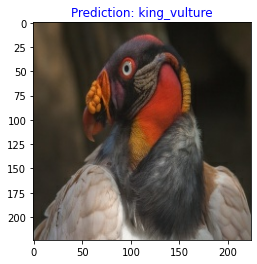

In [59]:
evaluate_random(p_experiment_exp_3, paths)

490, 0
1/1 [==============================] - 0s 69ms/step
187, 490


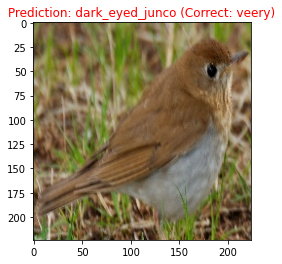

In [61]:
evaluate_random(p_experiment_exp_3, paths)

### Experiment 4. Add Capacity (depth)

In [67]:
def create_model_exp_4():
    inputs = keras.Input(shape=input_size)
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(filters=32, kernel_size=3, 
                      activation='relu', 
                      padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, 
                      activation='relu', 
                      padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, 
                      activation='relu', 
                      padding='same')(x)
    x = layers.Conv2D(filters=128, kernel_size=3, 
                      activation='relu', 
                      padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, 
                      activation='relu', 
                      padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, 
                      activation='relu', 
                      padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
                  
    return model

In [68]:
paths_exp_4 = update_paths(p_experiment_exp_4, paths)

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                     

{'loss': 2.686457633972168,
 'accuracy': 0.49533334374427795,
 'sparse_top_k_categorical_accuracy': 0.7201904654502869}

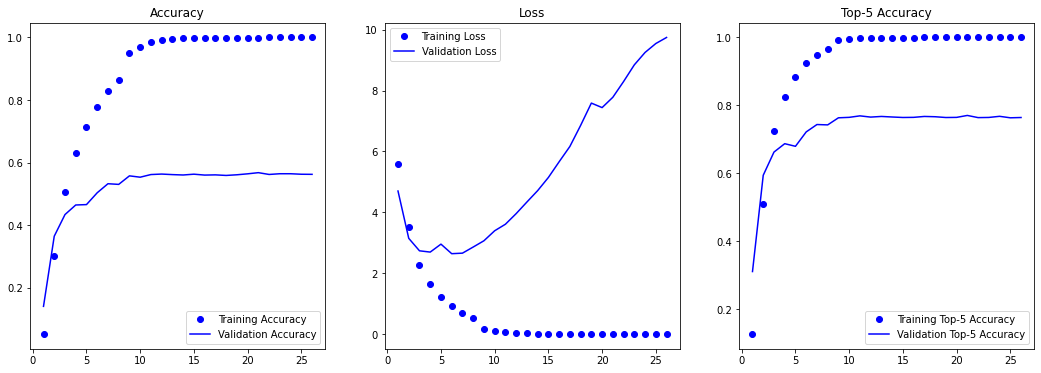

In [69]:
run_experiment(create_model_exp_4, paths_exp_4)

In [62]:
visualizeActivations(p_experiment_exp_4)

14, 4
1/1 [==============================] - 0s 394ms/step


In [63]:
visualizeMaxActivations(p_experiment_exp_4)

In [64]:
evaluate_cf(p_experiment_exp_4, paths)

165/165 [==============================] - 7s 37ms/step


137, 0
1/1 [==============================] - 0s 74ms/step
137, 137


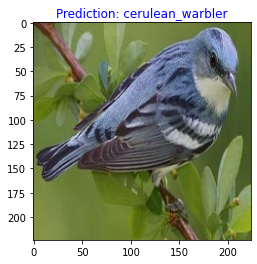

In [67]:
evaluate_random(p_experiment_exp_4, paths)

189, 5
1/1 [==============================] - 0s 77ms/step
507, 189


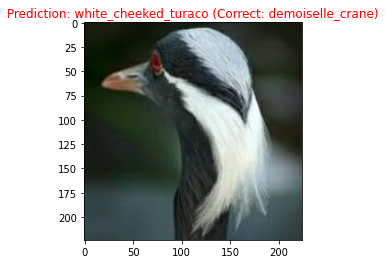

In [69]:
evaluate_random(p_experiment_exp_4, paths)

### Experiment 5. Add FC Dense layer

In [75]:
def create_model_exp_5():
    inputs = keras.Input(shape=input_size)
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(filters=32, kernel_size=3, 
                      activation='relu', 
                      padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, 
                      activation='relu', 
                      padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, 
                      activation='relu', 
                      padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, 
                      activation='relu', 
                      padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, 
                      activation='relu', 
                      padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
                  
    return model

In [76]:
paths_exp_5 = update_paths(p_experiment_exp_5, paths)

Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_41 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                     

{'loss': 2.5807747840881348,
 'accuracy': 0.4894285798072815,
 'sparse_top_k_categorical_accuracy': 0.7164762020111084}

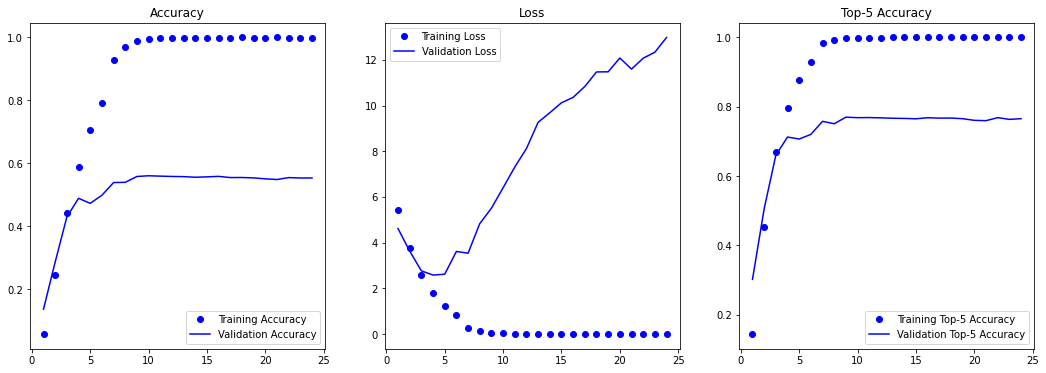

In [77]:
run_experiment(create_model_exp_5, paths_exp_5)

In [71]:
visualizeActivations(p_experiment_exp_5)

14, 4
1/1 [==============================] - 0s 74ms/step


In [72]:
visualizeMaxActivations(p_experiment_exp_5)

In [73]:
evaluate_cf(p_experiment_exp_5, paths)

165/165 [==============================] - 8s 50ms/step


380, 17
1/1 [==============================] - 0s 76ms/step
380, 380


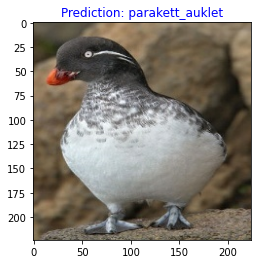

In [84]:
evaluate_random(p_experiment_exp_5, paths)

398, 8
1/1 [==============================] - 0s 76ms/step
262, 398


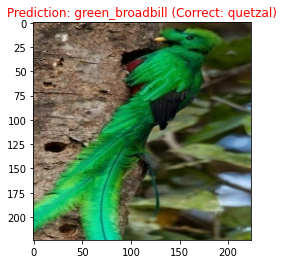

In [75]:
evaluate_random(p_experiment_exp_5, paths)

### Experiment 6. Adding Dropout

In [27]:
def create_model_exp_6():
    inputs = keras.Input(shape=input_size)
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(filters=32, kernel_size=3, 
                      activation='relu', 
                      padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, 
                      activation='relu', 
                      padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, 
                      activation='relu', 
                      padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, 
                      activation='relu', 
                      padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, 
                      activation='relu', 
                      padding='same')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(rate_dropout)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
                  
    return model

In [28]:
paths_exp_6 = update_paths(p_experiment_exp_6, paths)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                       

{'loss': 2.074759006500244,
 'accuracy': 0.5875238180160522,
 'sparse_top_k_categorical_accuracy': 0.7862856984138489}

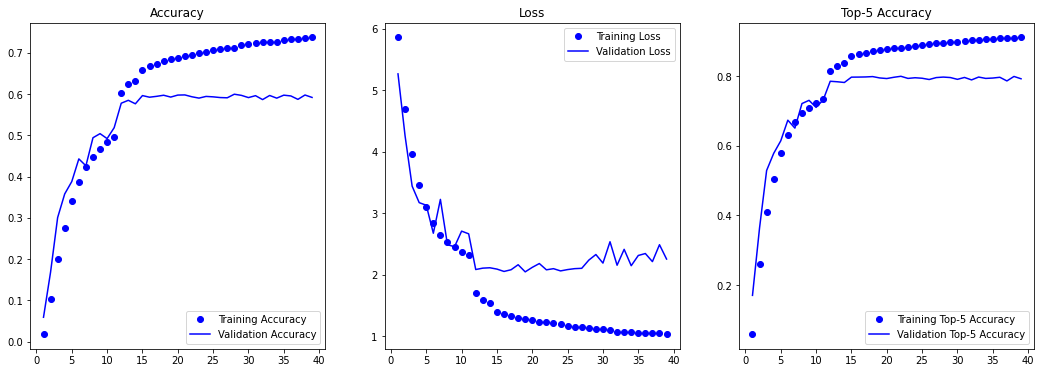

In [29]:
run_experiment(create_model_exp_6, paths_exp_6)

In [85]:
visualizeActivations(p_experiment_exp_6)

14, 4
1/1 [==============================] - 0s 74ms/step


In [86]:
visualizeMaxActivations(p_experiment_exp_6)

In [87]:
evaluate_cf(p_experiment_exp_6, paths)

165/165 [==============================] - 12s 70ms/step


0, 18
1/1 [==============================] - 0s 79ms/step
0, 0


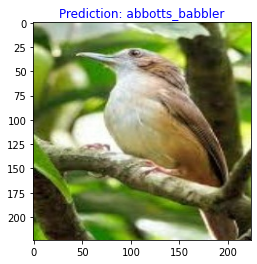

In [91]:
evaluate_random(p_experiment_exp_6, paths)

301, 5
1/1 [==============================] - 0s 80ms/step
373, 301


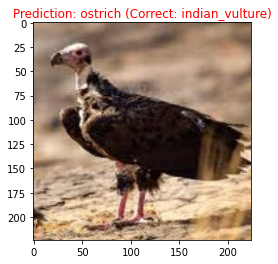

In [89]:
evaluate_random(p_experiment_exp_6, paths)

### Experiment 7: add residual connection

In [35]:
def create_model_exp_7():
    inputs = keras.Input(shape=input_size)
    x = layers.Rescaling(1./255)(inputs)
    x = add_residual_block(x, 32, 1)
    x = add_residual_block(x, 64, 1)
    x = add_residual_block(x, 128, 1)
    x = add_residual_block(x, 256, 1)
    x = add_residual_block(x, 256, 1, False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(rate_dropout)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
                  
    return model

In [36]:
paths_exp_7 = update_paths(p_experiment_exp_7, paths)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 224, 224, 32  896         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                            

{'loss': 1.3980333805084229,
 'accuracy': 0.7028571367263794,
 'sparse_top_k_categorical_accuracy': 0.8716190457344055}

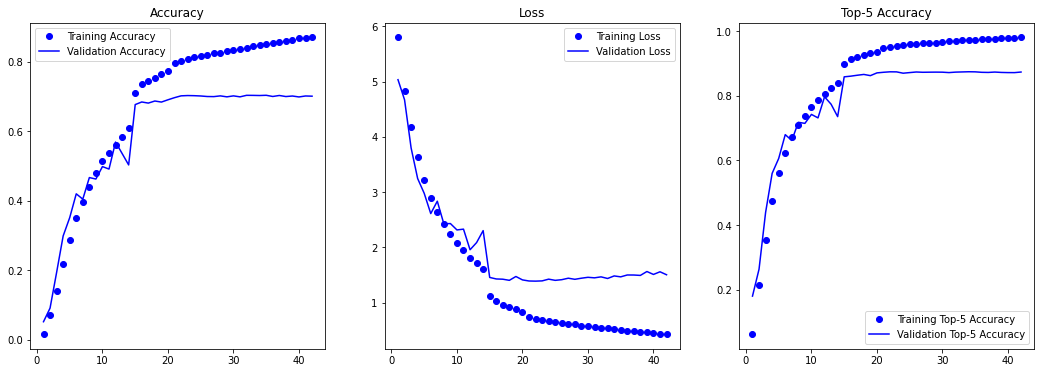

In [37]:
run_experiment(create_model_exp_7, paths_exp_7)

In [92]:
visualizeActivations(p_experiment_exp_7)

14, 4
1/1 [==============================] - 0s 189ms/step


In [93]:
visualizeMaxActivations(p_experiment_exp_7)

In [94]:
evaluate_cf(p_experiment_exp_7, paths)

165/165 [==============================] - 19s 115ms/step


281, 9
1/1 [==============================] - 0s 109ms/step
281, 281


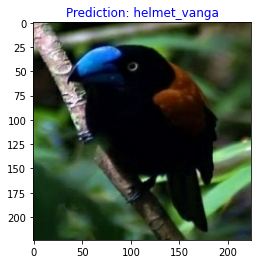

In [95]:
evaluate_random(p_experiment_exp_7, paths)

516, 13
1/1 [==============================] - 0s 109ms/step
518, 516


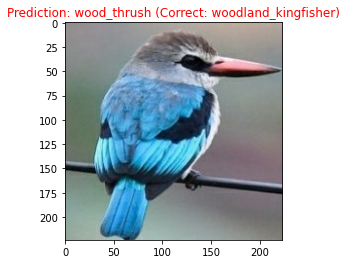

In [98]:
evaluate_random(p_experiment_exp_7, paths)

### Experiment 8: change to final pooling layer

In [43]:
def create_model_exp_8():
    inputs = keras.Input(shape=input_size)
    x = layers.Rescaling(1./255)(inputs)
    x = add_residual_block(x, 32, 1)
    x = add_residual_block(x, 64, 1)
    x = add_residual_block(x, 128, 1)
    x = add_residual_block(x, 256, 1)
    x = add_residual_block(x, 256, 1)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(rate_dropout)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
                  
    return model

In [44]:
paths_exp_8 = update_paths(p_experiment_exp_8, paths)

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv2d_14 (Conv2D)             (None, 224, 224, 32  896         ['rescaling_2[0][0]']            
                                )                                                                 
                                                                                           

{'loss': 2.052382230758667,
 'accuracy': 0.5675238370895386,
 'sparse_top_k_categorical_accuracy': 0.7707619071006775}

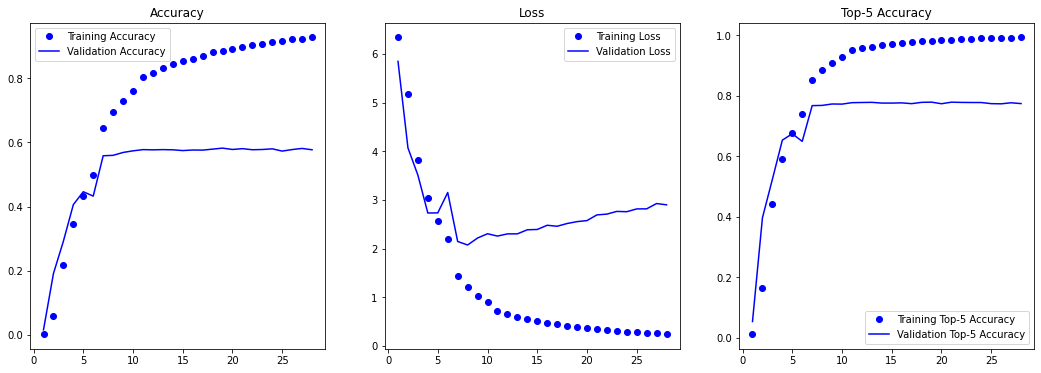

In [45]:
run_experiment(create_model_exp_8, paths_exp_8)

In [99]:
visualizeActivations(p_experiment_exp_8)

14, 4
1/1 [==============================] - 0s 144ms/step


In [100]:
visualizeMaxActivations(p_experiment_exp_8)

In [101]:
evaluate_cf(p_experiment_exp_8, paths)

165/165 [==============================] - 25s 152ms/step


0, 4
1/1 [==============================] - 0s 126ms/step
0, 0


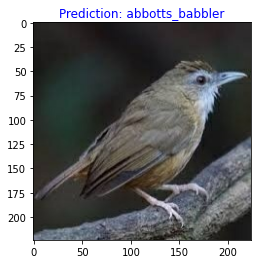

In [102]:
evaluate_random(p_experiment_exp_8, paths)

35, 19
1/1 [==============================] - 0s 121ms/step
256, 35


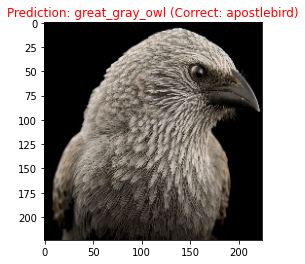

In [105]:
evaluate_random(p_experiment_exp_8, paths)

### Experiment 9: adding capacity to the model

In [51]:
def create_model_exp_9():
    inputs = keras.Input(shape=input_size)
    x = layers.Rescaling(1./255)(inputs)
    x = add_residual_block(x, 32, 2)
    x = add_residual_block(x, 64, 2)
    x = add_residual_block(x, 128, 2)
    x = add_residual_block(x, 256, 2)
    x = add_residual_block(x, 256, 1)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(rate_dropout)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
                  
    return model

In [52]:
paths_exp_9 = update_paths(p_experiment_exp_9, paths)

Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 224, 224, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 224, 224, 32  896         ['rescaling_3[0][0]']            
                                )                                                                 
                                                                                           

{'loss': 2.09112548828125,
 'accuracy': 0.5610476136207581,
 'sparse_top_k_categorical_accuracy': 0.7726666927337646}

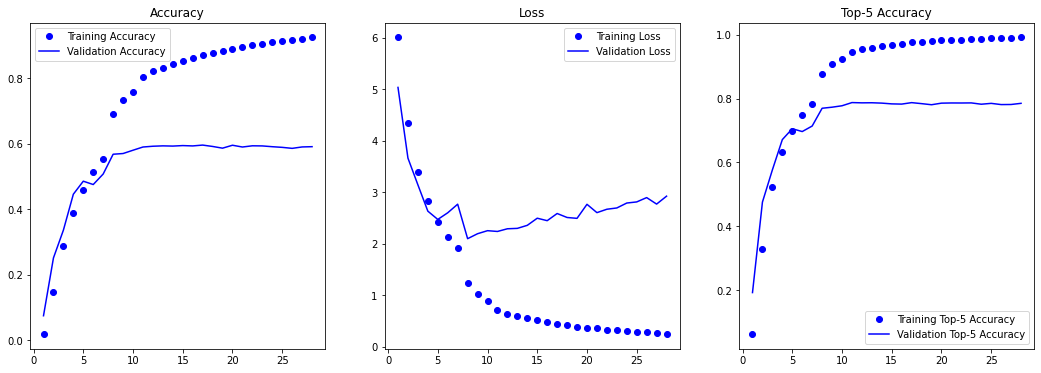

In [53]:
run_experiment(create_model_exp_9, paths_exp_9)

In [106]:
visualizeActivations(p_experiment_exp_9)

14, 4
1/1 [==============================] - 1s 540ms/step


In [23]:
visualizeMaxActivations(p_experiment_exp_9)

In [24]:
evaluate_cf(p_experiment_exp_9, paths)

165/165 [==============================] - 10s 50ms/step


41, 5
1/1 [==============================] - 0s 173ms/step
41, 41


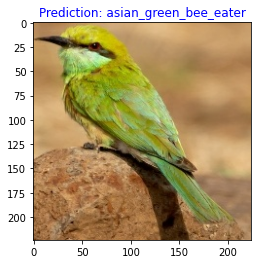

In [25]:
evaluate_random(p_experiment_exp_9, paths)

460, 4
1/1 [==============================] - 0s 132ms/step
52, 460


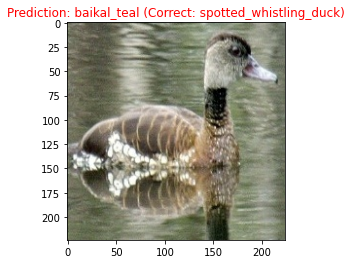

In [26]:
evaluate_random(p_experiment_exp_9, paths)

### Experiment 10: add data augmentation

In [23]:
def create_model_exp_10():
    augmentation_layer = create_augmentation_layer()
    
    inputs = keras.Input(shape=input_size)
    x = augmentation_layer(inputs)
    x = layers.Rescaling(1./255)(x)
    x = add_residual_block(x, 32, 1)
    x = add_residual_block(x, 64, 1)
    x = add_residual_block(x, 128, 1)
    x = add_residual_block(x, 256, 1)
    x = add_residual_block(x, 256, 1, False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(rate_dropout)(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
                  
    return model

In [24]:
paths_exp_10 = update_paths(p_experiment_exp_10, paths)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 32  896         ['rescaling[0][0]']        

{'loss': 1.399420976638794,
 'accuracy': 0.6987618803977966,
 'sparse_top_k_categorical_accuracy': 0.8711428642272949}

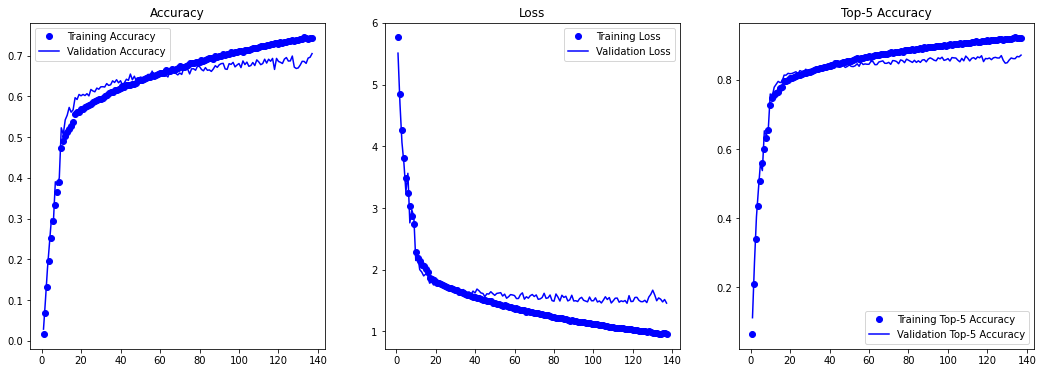

In [25]:
run_experiment(create_model_exp_10, paths_exp_10)

In [ ]:
visualizeActivations(p_experiment_exp_10)

14, 4
1/1 [==============================] - 1s 522ms/step


In [27]:
visualizeMaxActivations(p_experiment_exp_10)

In [28]:
evaluate_cf(p_experiment_exp_10, paths)

165/165 [==============================] - 6s 35ms/step


20, 10
1/1 [==============================] - 0s 104ms/step
20, 20


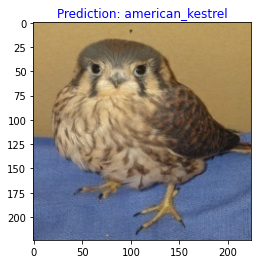

In [29]:
evaluate_random(p_experiment_exp_10, paths)

185, 2
1/1 [==============================] - 0s 101ms/step
279, 185


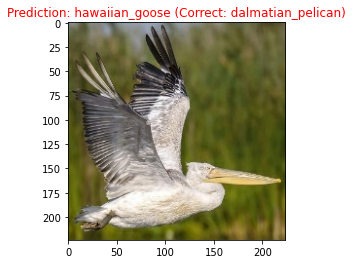

In [32]:
evaluate_random(p_experiment_exp_10, paths)

## Development Stage

### Experiment 11: VGG16

### Experiment 12: ResNet

### Experiment 13: Inception

### Experiment 14: Xception

### Experiment 15: MobileNet

### Experiment 16: DenseNet

### Experiment 17: EfficientNet